## Description:

    Investigate OTU classification in mock community



# Setting variables

In [1]:
workDir = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/MockCommunity/'
biomFileDir = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/OTU_binning/'

biomFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/OTU_binning/otu_table_wtax.biom'
metadataFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/metadata_RhizCG_merged.txt'
treeFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/fasttree/otusn.tree'

mockCommDir = '/home/bryan/RhizCG/data/MiSeq_amplicon/Hay-lab_mock_community/'

# Init

In [2]:
%load_ext rpy2.ipython

In [3]:
%%R
library(phyloseq)
library(ggplot2)
library(foreach)
library(doParallel)
library(gridExtra)
library(dplyr)
library(tidyr)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: foreach: simple, scalable parallel programming from Revolution Analytics
Use Revolution R for scalability, fault tolerance and more.
http://www.revolutionanalytics.com

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: iterators

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: parallel

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘dplyr’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from

# Loading/editting OTU table

In [4]:
%%R -i biomFile -i metadataFile -i workDir -i treeFile
# loading
setwd(workDir)

## biom file
physeq = import_biom(biomFile, treeFile)

## loading sample metadata
sample.data = import_qiime_sample_data(metadataFile)
physeq = merge_phyloseq(physeq,sample.data)

print(physeq)

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 11246 taxa and 249 samples ]
sample_data() Sample Data:       [ 249 samples by 21 sample variables ]
tax_table()   Taxonomy Table:    [ 11246 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 11246 tips and 11245 internal nodes ]


### apply gsub across columns replacing __ w/ "" reload tax_table to phyloseq object

In [5]:
%%R
t = tax_table(physeq)
t = apply(t, 2, function(y) gsub("__", "", y))
tax_table(physeq) = t

### Filter by removing taxa not seen in more than  3 counts in more than 3 samples  

In [6]:
%%R 

# filtering/normalizing
#physeq.snorm = transform_sample_counts(physeq, function(x) x/sum(x))
physeq.thresh = filter_taxa(physeq, function(x) sum(x > 3) > 3, TRUE)
print(physeq.thresh)

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4987 taxa and 249 samples ]
sample_data() Sample Data:       [ 249 samples by 21 sample variables ]
tax_table()   Taxonomy Table:    [ 4987 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4987 tips and 4986 internal nodes ]


## Controls 

In [7]:
%%R
Controls = subset_samples(physeq.thresh, is.na(DAP))
Controls = prune_taxa(taxa_sums(Controls) > 0, Controls)
print(Controls)

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 201 taxa and 9 samples ]
sample_data() Sample Data:       [ 9 samples by 21 sample variables ]
tax_table()   Taxonomy Table:    [ 201 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 201 tips and 200 internal nodes ]


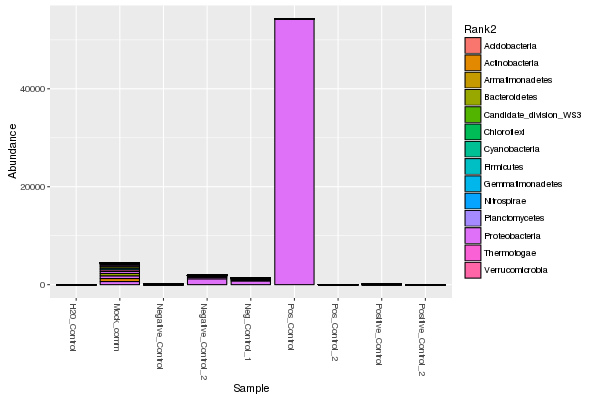

In [8]:
%%R -w 600 -h 400
plot_bar(Controls, fill = 'Rank2', x = "Sample")

In [9]:
%%R
Mock = subset_samples(physeq, X.sample == "Mock_comm")
Mock = prune_taxa(taxa_sums(Mock) > 0, Mock)

Pos = subset_samples(physeq, X.sample == "Pos_Control")
Pos = prune_taxa(taxa_sums(Pos) > 0, Pos)
tax_table(Pos)
unique(tax_table(Mock))

Taxonomy Table:     [36 taxa by 8 taxonomic ranks]:
          Rank1      Rank2             Rank3                  
OTU.409   "Bacteria" "Acidobacteria"   "Holophagae"           
OTU.1116  "Bacteria" "Verrucomicrobia" "Verrucomicrobiae"     
OTU.2936  "Bacteria" "Acidobacteria"   "Acidobacteriales"     
OTU.2132  "Bacteria" "Bacteroidetes"   "Sphingobacteriia"     
OTU.4013  "Bacteria" "Bacteroidetes"   "Flavobacteria"        
OTU.653   "Bacteria" "Bacteroidetes"   "Flavobacteria"        
OTU.6162  "Bacteria" "Acidobacteria"   "DA023"                
OTU.5957  "Bacteria" "Firmicutes"      "Bacilli"              
OTU.8456  "Bacteria" "Firmicutes"      "Bacilli"              
OTU.7459  "Bacteria" "Firmicutes"      "Bacilli"              
OTU.4596  "Bacteria" "Firmicutes"      "Bacilli"              
OTU.121   "Bacteria" "Firmicutes"      "Bacilli"              
OTU.8113  "Bacteria" "Firmicutes"      "Bacilli"              
OTU.8342  "Bacteria" "Firmicutes"      "Bacilli"              
OTU

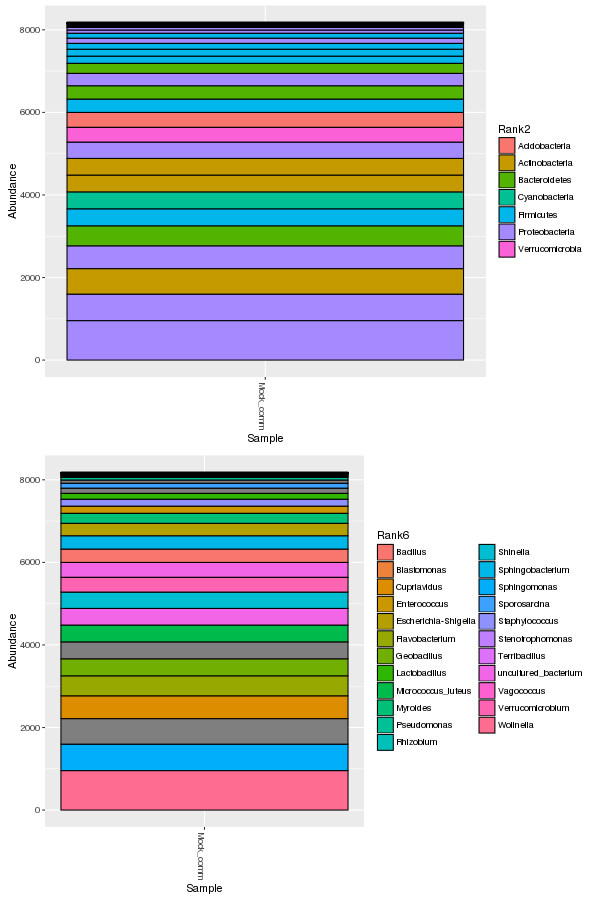

In [10]:
%%R -w 600 -h 900
p1 = plot_bar(Mock, fill = 'Rank2', x = "Sample")

p2 = plot_bar(Mock, fill = 'Rank6', x = "Sample")

grid.arrange(p1, p2, ncol=1)

# Comparing mock community OTU composition to table of 'true' mock community composition

In [11]:
%%R -i mockCommDir
setwd(mockCommDir)

mock.known = read.delim('strain_taxonomy.txt', sep='\t')

mock.known = mock.known$phylum %>% table %>% as.data.frame
colnames(mock.known) = c('phylum', 'freq.known')

mock.known = mock.known %>%
    group_by() %>%
    mutate(freq.known.norm = freq.known / sum(freq.known))

mock.known %>% head

Source: local data frame [5 x 3]

          phylum freq.known freq.known.norm
          (fctr)      (int)           (dbl)
1 Actinobacteria          4      0.10526316
2  Bacteroidetes          2      0.05263158
3     Firmicutes          8      0.21052632
4 Proteobacteria         23      0.60526316
5   Spirochaetes          1      0.02631579


## Comparing relative compositions of phylum

In [12]:
%%R

Mock.snorm = transform_sample_counts(Mock, function(x) x/sum(x))

tbl.otu = Mock.snorm %>% otu_table %>% as.data.frame
tbl.otu$otu = rownames(tbl.otu)

tbl.otu = tbl.otu %>%
    gather('sample', 'abundance', 1:(ncol(tbl.otu)-1)) %>%
    group_by(otu) %>%
    mutate(total_abund = sum(abundance))

tbl.otu

Source: local data frame [43 x 4]
Groups: otu [43]

        otu    sample    abundance  total_abund
      (chr)     (chr)        (dbl)        (dbl)
1   OTU.409 Mock_comm 0.0001222344 0.0001222344
2  OTU.1116 Mock_comm 0.0438821660 0.0438821660
3  OTU.2936 Mock_comm 0.0438821660 0.0438821660
4  OTU.2132 Mock_comm 0.0393594915 0.0393594915
5  OTU.4013 Mock_comm 0.0299474392 0.0299474392
6   OTU.653 Mock_comm 0.0001222344 0.0001222344
7  OTU.9530 Mock_comm 0.0592837061 0.0592837061
8  OTU.6162 Mock_comm 0.0001222344 0.0001222344
9  OTU.5957 Mock_comm 0.0210243247 0.0210243247
10 OTU.8456 Mock_comm 0.0173572913 0.0173572913
..      ...       ...          ...          ...


In [13]:
%%R
tbl.tax = Mock.snorm %>% tax_table %>% as.data.frame
tbl.tax$otu = rownames(tbl.tax)

tbl.j = inner_join(tbl.otu, tbl.tax, c('otu' = 'otu'))
tbl.j %>% head(n=3)

Source: local data frame [3 x 12]
Groups: otu [3]

       otu    sample    abundance  total_abund    Rank1           Rank2
     (chr)     (chr)        (dbl)        (dbl)   (fctr)          (fctr)
1  OTU.409 Mock_comm 0.0001222344 0.0001222344 Bacteria   Acidobacteria
2 OTU.1116 Mock_comm 0.0438821660 0.0438821660 Bacteria Verrucomicrobia
3 OTU.2936 Mock_comm 0.0438821660 0.0438821660 Bacteria   Acidobacteria
Variables not shown: Rank3 (fctr), Rank4 (fctr), Rank5 (fctr), Rank6 (fctr),
  Rank7 (fctr), Rank8 (fctr)


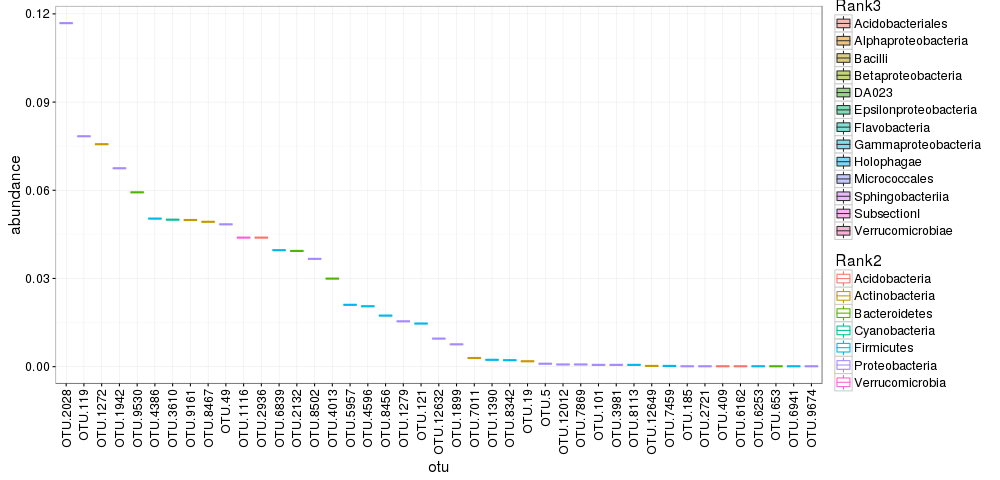

In [14]:
%%R -w 1000 

tbl.j$otu = reorder(tbl.j$otu, -tbl.j$total_abund)

ggplot(tbl.j, aes(otu, abundance, color=Rank2, fill=Rank3)) +
    geom_boxplot(alpha=0.5) +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x = element_text(angle=90, vjust=0.5, hjust=1)
        )

In [15]:
%%R 
# mock communities from sequence data

tmp = tbl.j %>% 
    group_by(otu, Rank2) %>%
    summarize(n=n()) %>%
    ungroup() %>%
    select(Rank2) 

mock.est = tmp$Rank2 %>% table %>% as.data.frame
colnames(mock.est) = c('phylum', 'freq.est')

mock.est = mock.est %>%
    group_by() %>%
    mutate(freq.est.norm = freq.est / sum(freq.est))

mock.est 

Source: local data frame [7 x 3]

           phylum freq.est freq.est.norm
           (fctr)    (int)         (dbl)
1   Acidobacteria        3    0.06976744
2  Actinobacteria        6    0.13953488
3   Bacteroidetes        4    0.09302326
4   Cyanobacteria        1    0.02325581
5      Firmicutes       12    0.27906977
6  Proteobacteria       16    0.37209302
7 Verrucomicrobia        1    0.02325581


In [16]:
%%R

mock.j = full_join(mock.est, mock.known, c('phylum' = 'phylum')) %>%
    gather('variable', 'value', freq.est.norm, freq.known.norm) 

mock.j

Source: local data frame [16 x 5]

            phylum freq.est freq.known        variable      value
             (chr)    (int)      (int)           (chr)      (dbl)
1    Acidobacteria        3         NA   freq.est.norm 0.06976744
2   Actinobacteria        6          4   freq.est.norm 0.13953488
3    Bacteroidetes        4          2   freq.est.norm 0.09302326
4    Cyanobacteria        1         NA   freq.est.norm 0.02325581
5       Firmicutes       12          8   freq.est.norm 0.27906977
6   Proteobacteria       16         23   freq.est.norm 0.37209302
7  Verrucomicrobia        1         NA   freq.est.norm 0.02325581
8     Spirochaetes       NA          1   freq.est.norm         NA
9    Acidobacteria        3         NA freq.known.norm         NA
10  Actinobacteria        6          4 freq.known.norm 0.10526316
11   Bacteroidetes        4          2 freq.known.norm 0.05263158
12   Cyanobacteria        1         NA freq.known.norm         NA
13      Firmicutes       12          8 fr

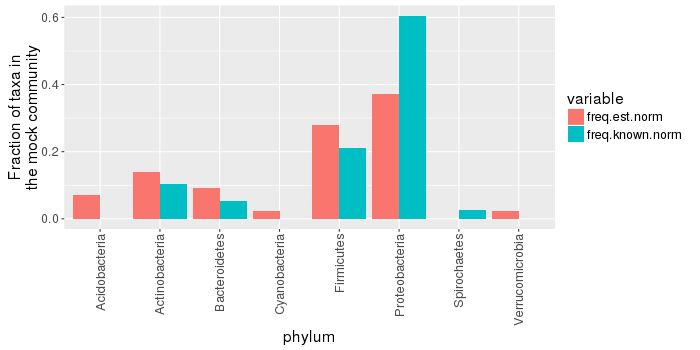

In [17]:
%%R -w 700 -h 350

ggplot(mock.j, aes(phylum, value, fill=variable)) +
    geom_bar(stat='identity', position='dodge') +
    labs(y='Fraction of taxa in\nthe mock community') +
    theme(
        text = element_text(size=16),
        axis.text.x = element_text(angle=90, vjust=0.5, hjust=1)
        )

### Filtering out low abundance taxa

In [18]:
%%R 
# mock communities from sequence data

tmp = tbl.j %>% 
    filter(abundance > 0.01) %>%
    mutate(Rank2 = gsub('^__', '', Rank2)) %>%
    group_by(otu, Rank2) %>%
    summarize(n=n()) %>%
    ungroup() %>%
    select(Rank2) 

mock.est = tmp$Rank2 %>% table %>% as.data.frame
colnames(mock.est) = c('phylum', 'freq.est')

mock.est = mock.est %>%
    group_by() %>%
    mutate(freq.est.norm = freq.est / sum(freq.est))

mock.est 

Source: local data frame [7 x 3]

           phylum freq.est freq.est.norm
           (fctr)    (int)         (dbl)
1   Acidobacteria        1    0.04761905
2  Actinobacteria        3    0.14285714
3   Bacteroidetes        3    0.14285714
4   Cyanobacteria        1    0.04761905
5      Firmicutes        6    0.28571429
6  Proteobacteria        6    0.28571429
7 Verrucomicrobia        1    0.04761905


In [19]:
%%R

mock.j = left_join(mock.est, mock.known, c('phylum' = 'phylum')) %>%
    gather('variable', 'value', freq.est.norm, freq.known.norm)

mock.j %>% head

Source: local data frame [6 x 5]

          phylum freq.est freq.known      variable      value
           (chr)    (int)      (int)         (chr)      (dbl)
1  Acidobacteria        1         NA freq.est.norm 0.04761905
2 Actinobacteria        3          4 freq.est.norm 0.14285714
3  Bacteroidetes        3          2 freq.est.norm 0.14285714
4  Cyanobacteria        1         NA freq.est.norm 0.04761905
5     Firmicutes        6          8 freq.est.norm 0.28571429
6 Proteobacteria        6         23 freq.est.norm 0.28571429


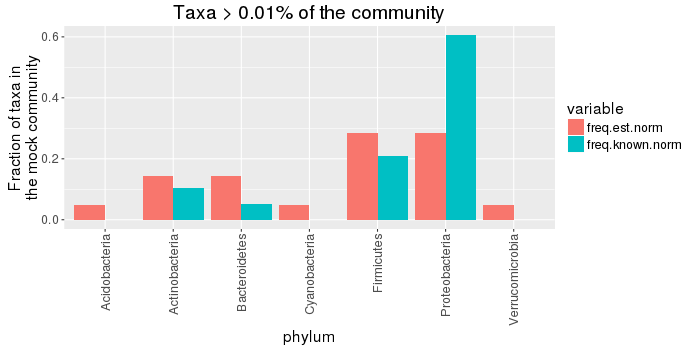

In [20]:
%%R -w 700 -h 350

ggplot(mock.j, aes(phylum, value, fill=variable)) +
    geom_bar(stat='identity', position='dodge') +
    labs(y='Fraction of taxa in\nthe mock community', title='Taxa > 0.01% of the community') +
    theme(
        text = element_text(size=16),
        axis.text.x = element_text(angle=90, vjust=0.5, hjust=1)
        )

## Comparing relative compositions of 

In [21]:
%%R -i mockCommDir
setwd(mockCommDir)

mock.known = read.delim('strain_taxonomy.txt', sep='\t')

mock.known = mock.known$genus %>% table %>% as.data.frame
colnames(mock.known) = c('genus', 'freq.known')

mock.known = mock.known %>%
    group_by() %>%
    mutate(freq.known.norm = freq.known / sum(freq.known))

mock.known %>% head

Source: local data frame [6 x 3]

          genus freq.known freq.known.norm
         (fctr)      (int)           (dbl)
1 Achromobacter          1      0.02631579
2 Agrobacterium          1      0.02631579
3   Alcaligenes          2      0.05263158
4  Arthrobacter          1      0.02631579
5      Bacillus          2      0.05263158
6  Enterobacter          1      0.02631579


In [22]:
%%R 
# mock communities from sequence data

tmp = tbl.j %>% 
    mutate(Rank6 = gsub('^__', '', Rank6), 
           Rank6 = gsub('uncultured_', '', Rank6)) %>%
    group_by(otu, Rank6) %>%
    summarize(n=n()) %>%
    ungroup() %>%
    select(Rank6) 

mock.est = tmp$Rank6 %>% table %>% as.data.frame
colnames(mock.est) = c('genus', 'freq.est')

mock.est = mock.est %>%
    group_by() %>%
    mutate(freq.est.norm = freq.est / sum(freq.est))

mock.est %>% head

Source: local data frame [6 x 3]

                 genus freq.est freq.est.norm
                (fctr)    (int)         (dbl)
1             Bacillus        4       0.12500
2            bacterium        3       0.09375
3          Blastomonas        1       0.03125
4          Cupriavidus        1       0.03125
5         Enterococcus        1       0.03125
6 Escherichia-Shigella        1       0.03125


In [23]:
%%R

mock.j = full_join(mock.est, mock.known, c('genus' = 'genus')) %>%
    gather('variable', 'value', freq.est.norm, freq.known.norm) %>%
    group_by(variable)

mock.j %>% head

Source: local data frame [6 x 5]
Groups: variable [1]

                 genus freq.est freq.known      variable   value
                 (chr)    (int)      (int)         (chr)   (dbl)
1             Bacillus        4          2 freq.est.norm 0.12500
2            bacterium        3         NA freq.est.norm 0.09375
3          Blastomonas        1         NA freq.est.norm 0.03125
4          Cupriavidus        1         NA freq.est.norm 0.03125
5         Enterococcus        1          1 freq.est.norm 0.03125
6 Escherichia-Shigella        1         NA freq.est.norm 0.03125


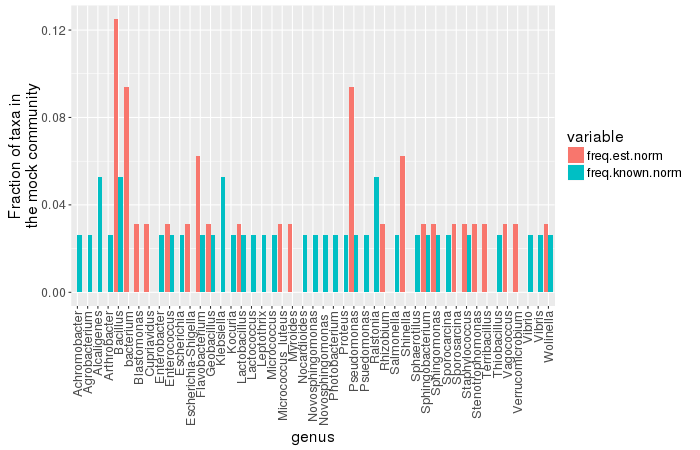

In [24]:
%%R -w 700 -h 450

ggplot(mock.j, aes(genus, value, fill=variable)) +
    geom_bar(stat='identity', position='dodge') +
    labs(y='Fraction of taxa in\nthe mock community') +
    theme(
        text = element_text(size=16),
        axis.text.x = element_text(angle=90, vjust=0.5, hjust=1)
        )

### Conclusions

* The number of OTUs in the sequenced mock is pretty similar to the actual number of taxa in the community
  * 43 estimated compared to 39 actual
* The community composition between sequenced and true communities is:
  * Similar at the phylum level
  * Not too accurate at the genus level

## Identify taxa in negative controls

In [25]:
%%R -w 600 -h 900

p1 = plot_bar(Control, fill = 'Rank2', x = "Sample")

p2 = plot_bar(Control, fill = 'Rank5', x = "Sample") +
        theme_bw() +
        theme(plot.title = element_text(face="bold", size=20)) +
        guides(fill=guide_legend(ncol=2))

grid.arrange(p1, p2, ncol=1)


Error in inherits(physeq, "phyloseq") : object 'Control' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in inherits(physeq, "phyloseq") : object 'Control' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: In addition: 
  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Warning messages:

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 1: replacing previous import ‘S4Vectors::Position’ by ‘ggplot2::Position’ when loading ‘DESeq2’ 

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 2: 
  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/

In [26]:
%%R
pdf(file = "/home/bryan/RhizCG/figures/diagnostics/NegControl.pdf", height = 8, width = 6)
grid.arrange(p1, p2, ncol=1)
dev.off()

png 
  2 


## Save OTUs in negative controls

In [27]:
%%R
NegControl = subset_samples(physeq.thresh, X.sample %in% c("Neg_Control_1", 
                                                    "Negative_Control_2", "H20_Control", "Negative_Control"))

NegControl
#NegControl = prune_taxa(taxa_sums(NegControl) > 0, NegControl)

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4987 taxa and 4 samples ]
sample_data() Sample Data:       [ 4 samples by 21 sample variables ]
tax_table()   Taxonomy Table:    [ 4987 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4987 tips and 4986 internal nodes ]


In [28]:
%%R
FalsePositives = filter_taxa(NegControl, function(x) sum(x > 0) > 0, TRUE) %>% taxa_names()
     

In [29]:
%%R
FalsePositives = filter_taxa(NegControl, function(x) sum(x > 0) > 0, TRUE) %>% taxa_names()

Positives = filter_taxa(NegControl, function(x) sum(x > 0) < 1, TRUE) %>% taxa_names()

physeq.FP = prune_taxa(FalsePositives, physeq.thresh)  
physeq.P = prune_taxa(Positives, physeq.thresh)   

physeq.P


phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4868 taxa and 249 samples ]
sample_data() Sample Data:       [ 249 samples by 21 sample variables ]
tax_table()   Taxonomy Table:    [ 4868 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4868 tips and 4867 internal nodes ]


In [45]:
%%R
sort(taxa_sums(NegControl), TRUE) %>% print

   OTU.21    OTU.10  OTU.9501    OTU.19  OTU.8768  OTU.4280  OTU.2087   OTU.101 
     1351      1083       271       125        84        74        33        30 
 OTU.2275   OTU.147  OTU.1166   OTU.470   OTU.641 OTU.10288   OTU.126 OTU.11593 
       26        25        22        16        16        13        12        11 
  OTU.644   OTU.182  OTU.1312     OTU.5  OTU.9752  OTU.1876 OTU.10708   OTU.763 
       10         9         9         9         9         9         8         7 
 OTU.8282   OTU.672 OTU.12324   OTU.235  OTU.1650 OTU.12632  OTU.1899  OTU.1403 
        7         6         6         6         5         5         5         5 
 OTU.9331  OTU.9377  OTU.6965   OTU.127  OTU.9354  OTU.4340   OTU.151    OTU.48 
        4         4         3         3         3         3         2         2 
    OTU.8    OTU.22 OTU.10294     OTU.7  OTU.2285   OTU.583    OTU.44   OTU.186 
        2         2         2         2         2         2         1         1 
  OTU.400   OTU.115   OTU.83

In [30]:
%%R
FP_rel = sample_sums(physeq.FP) / sample_sums(physeq.thresh)
FP_rel

 sample2-1.06_Npos  sample6-4.27_Npos  sample4-4.27_Nneg  sample4-1.06_Nneg 
        0.11274832         0.11383558         0.11398244         0.11600873 
 sample2-1.06_Nneg  sample6-3.07_Nneg  sample5-3.07_Nneg  sample6-3.07_Npos 
        0.11414539         0.10886910         0.11031502         0.11187919 
 sample3-3.07_Npos  sample5-1.22_Nneg  sample6-4.12_Npos  sample1-4.27_Npos 
        0.11559749         0.19193242         0.19954501         0.11391775 
 sample4-1.03_Npos  sample5-2.06_Npos  sample5-4.08_Npos  sample4-3.07_Nneg 
        0.16071166         0.18325123         0.19454339         0.11212467 
 sample5-4.28_Npos  sample6-1.06_Npos  sample4-2.05_Nneg  sample2-4.27_Nneg 
        0.14919990         0.10954617         0.12245130         0.11465387 
 sample1-2.05_Nneg  sample5-1.29_Npos  sample5-4.27_Npos  sample5-4.27_Nneg 
        0.12226586         0.22363999         0.11076673         0.11243518 
 sample1-3.07_Nneg  sample4-2.02_Nneg  sample4-4.21_Nneg  sample2-2.05_Nneg 

In [31]:
%%R
physeq.snorm = transform_sample_counts(physeq.thresh, function(x) x/sum(x))
physeq.snorm = subset_samples(physeq.snorm, !is.na(Plant))
physeq.snormP = transform_sample_counts(physeq.P, function(x) x/sum(x))
physeq.snormP = subset_samples(physeq.snormP, !is.na(Plant))
physeq.snormFP = prune_taxa(FalsePositives, physeq.snorm)

# ordinate to view difference between positives and full object

## Calculate pairwise weighted Unifrac distances between samples

In [32]:
%%R
registerDoParallel(cores=28)
wunif.dist = distance(physeq.snorm, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

wunif.dist.P = distance(physeq.snormP, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

## NMDS of w-Unifrac

In [33]:
%%R -w 1200 -h 350

nmds1 = ordinate(physeq.snorm, 
                method = "NMDS", 
                distance = wunif.dist)

nmds2  = ordinate(physeq.snormP, 
                method = "NMDS", 
                distance = wunif.dist.P)



Run 0 stress 0.1405905 
Run 1 stress 0.1453516 
Run 2 stress 0.1688805 
Run 3 stress 0.1434841 
Run 4 stress 0.1754966 
Run 5 stress 0.1453515 
Run 6 stress 0.170699 
Run 7 stress 0.1434585 
Run 8 stress 0.1739166 
Run 9 stress 0.1503242 
Run 10 stress 0.1405876 
... New best solution
... procrustes: rmse 0.001915051  max resid 0.02826877 
Run 11 stress 0.1420524 
Run 12 stress 0.1538235 
Run 13 stress 0.1430799 
Run 14 stress 0.1635972 
Run 15 stress 0.1544995 
Run 16 stress 0.1885301 
Run 17 stress 0.1701339 
Run 18 stress 0.1694888 
Run 19 stress 0.1433949 
Run 20 stress 0.1551829 
Run 0 stress 0.1460777 
Run 1 stress 0.1765484 
Run 2 stress 0.1527412 
Run 3 stress 0.1894492 
Run 4 stress 0.1524941 
Run 5 stress 0.1460759 
... New best solution
... procrustes: rmse 0.0002268604  max resid 0.002208924 
*** Solution reached


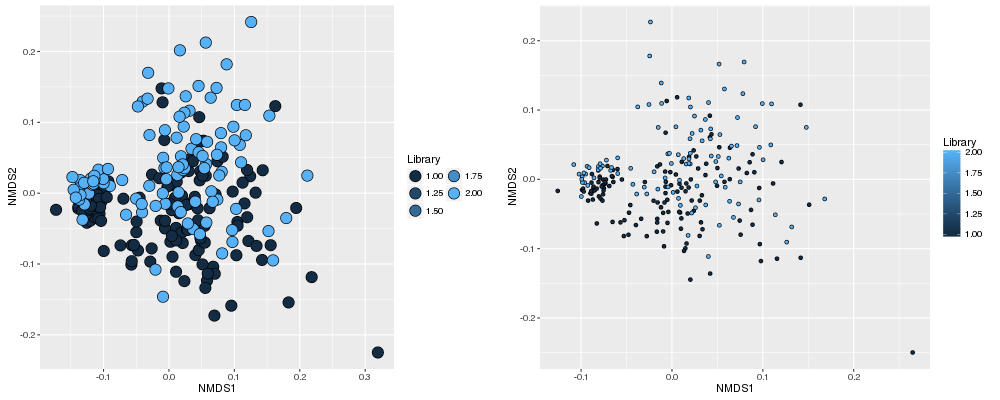

In [34]:
%%R -w 1000 -h 400
p = plot_ordination(physeq.snorm, nmds1, justDF = TRUE)

pP = plot_ordination(physeq.snormP, nmds2, justDF = TRUE)
## generating plots

p1 = ggplot(p, aes(x = NMDS1, y = NMDS2)) +
        geom_point(aes(fill=Library), pch = 21, size = 5) +
        guides(fill=guide_legend(ncol=2))
        #scale_size(range=c(2,8))

p2 = ggplot(pP, aes(x = NMDS1, y = NMDS2)) +
        geom_point(aes(fill=Library), pch=21) +
        scale_size(range=c(2,8))

grid.arrange(p1,p2, ncol=2)

In [35]:
%%R 
outFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/physeq/FalsePositives'
saveRDS(physeq.FP, outFile)

outFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/physeq/Positives'
saveRDS(physeq.P, outFile)

outFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/physeq/Positives_rel'
saveRDS(physeq.snormP, outFile) 


## Plot rank relative abundance of false positives

In [36]:
%%R -w 600 -h 400

pdf("/home/bryan/RhizCG/figures/FP-sample_relabundance.pdf", onefile = TRUE)


N = nsamples(physeq.snormFP)

s.df = sample_data(physeq.snormFP)
s.df.o =  s.df[with(s.df, order(Plant, Treatment))]
samples = sample_names(s.df.o)

for(i in 1:N){
    samplename = samples[i]
    sample = subset_samples(physeq.snorm, X.sample == samplename)
  

    TopOTUs = names(sort(taxa_sums(sample), TRUE)[1:50])
    Top = prune_taxa(TopOTUs, sample)
    title = paste(sample_data(Top)$Plant, samplename, sample_sums(Top), sep = " ")
    plot =  barplot(sort(taxa_sums(Top), TRUE), las=2, 
        main = title)
    plot
}

dev.off()



png 
  2 


In [37]:
%%R
NegControl

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4987 taxa and 4 samples ]
sample_data() Sample Data:       [ 4 samples by 21 sample variables ]
tax_table()   Taxonomy Table:    [ 4987 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4987 tips and 4986 internal nodes ]


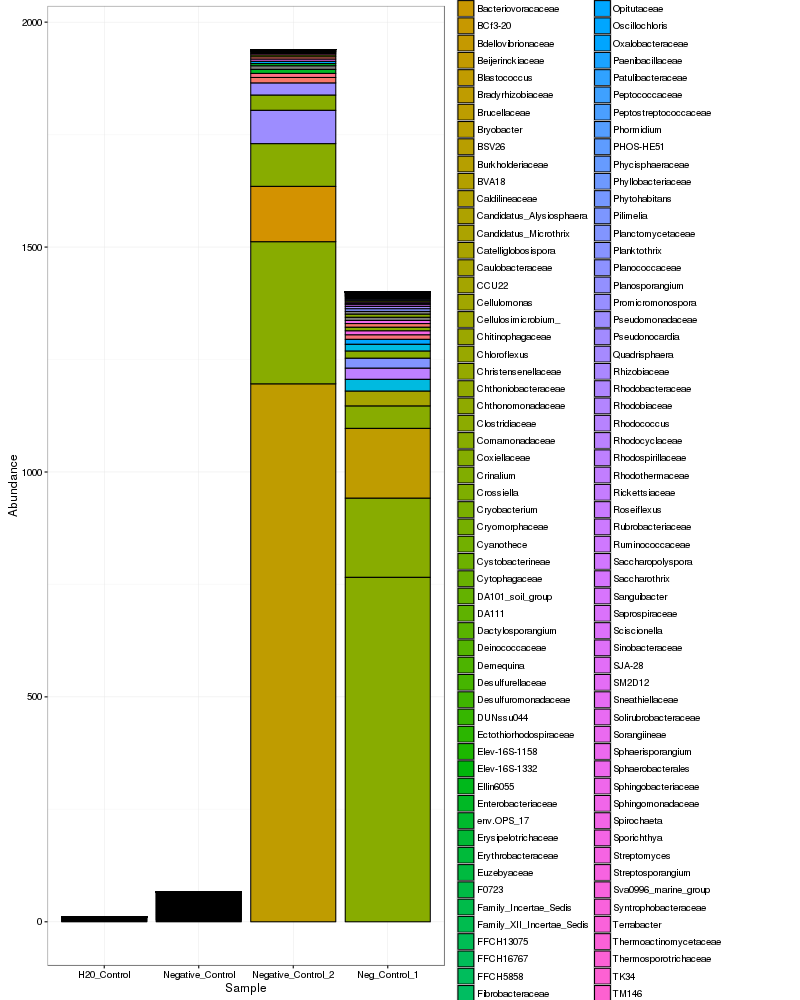

In [38]:
%%R -h 1000 -w 800
p2 = plot_bar(NegControl, fill = 'Rank5', x = "Sample") +
        theme_bw() +
        theme(plot.title = element_text(face="bold", size=20)) +
        guides(fill=guide_legend(ncol=2))
p2